## Library

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import torchvision
import tensorflow as tf 
keras=tf.keras
from keras.datasets import fashion_mnist

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

In [3]:
fashion=np.load('/content/drive/MyDrive/Adv ML Dataset/archive.zip')

In [4]:
fashion.files

['fashion-mnist_test.csv',
 'fashion-mnist_train.csv',
 't10k-images-idx3-ubyte',
 't10k-labels-idx1-ubyte',
 'train-images-idx3-ubyte',
 'train-labels-idx1-ubyte']

In [5]:
train_images=fashion['train-images-idx3-ubyte']
train_labels=fashion['train-labels-idx1-ubyte']

In [6]:
test_images=fashion['t10k-images-idx3-ubyte']
test_labels=fashion['t10k-labels-idx1-ubyte']

## Dataloader

In [7]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [8]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('train_images', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('test_images', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting train_images/MNIST/raw/train-images-idx3-ubyte.gz to train_images/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting train_images/MNIST/raw/train-labels-idx1-ubyte.gz to train_images/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting train_images/MNIST/raw/t10k-images-idx3-ubyte.gz to train_images/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting train_images/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_images/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting test_images/MNIST/raw/train-images-idx3-ubyte.gz to test_images/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting test_images/MNIST/raw/train-labels-idx1-ubyte.gz to test_images/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting test_images/MNIST/raw/t10k-images-idx3-ubyte.gz to test_images/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting test_images/MNIST/raw/t10k-labels-idx1-ubyte.gz to test_images/MNIST/raw



## Visualization

In [9]:
(trainx, trainy), (testx, testy) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [10]:
print(trainx.shape)

(60000, 28, 28)


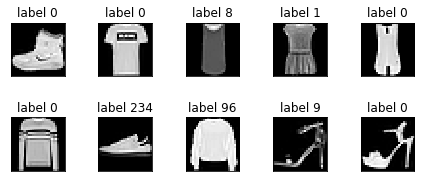

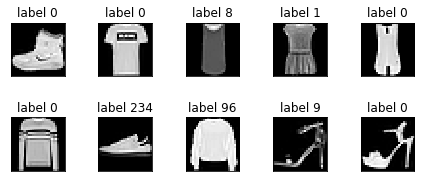

In [11]:
fig = plt.figure()
for i in range(10):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(trainx[i], cmap='gray', interpolation='none')
  plt.title("label {}".format(train_labels[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [12]:
print(testx.shape)

(10000, 28, 28)


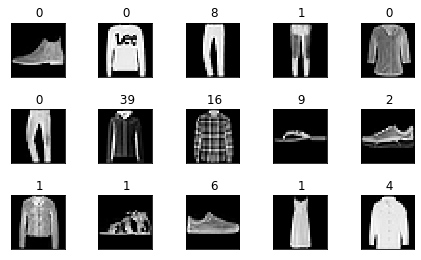

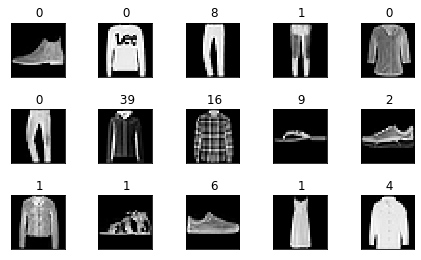

In [13]:
fig = plt.figure()
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.tight_layout()
  plt.imshow(testx[i], cmap='gray', interpolation='none')
  plt.title(" {}".format(test_labels[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Building the Network

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [16]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [17]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [18]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [19]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.cross_entropy(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [20]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-15-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.373700
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.941021
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.268569
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.196833
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.908022
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.907190
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.943569
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.947616
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.876515
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.709492
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.817212
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.621218
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.898039
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.916898
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.659446
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.639238
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.811678
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.614909
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.667899
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.385294
Train Epoch: 1 [12800/60000 (

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1361, Accuracy: 9652/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.516372
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.361994
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.415482
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.268836
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.422902
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.541596
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.587720
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.419936
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.642894
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.294348
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.276467
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.663025
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.161346
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.546869
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.550076
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.444706
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.427740
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.327635
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.507262
Train Epoch: 2 [12160

 ***Experimental Model***

 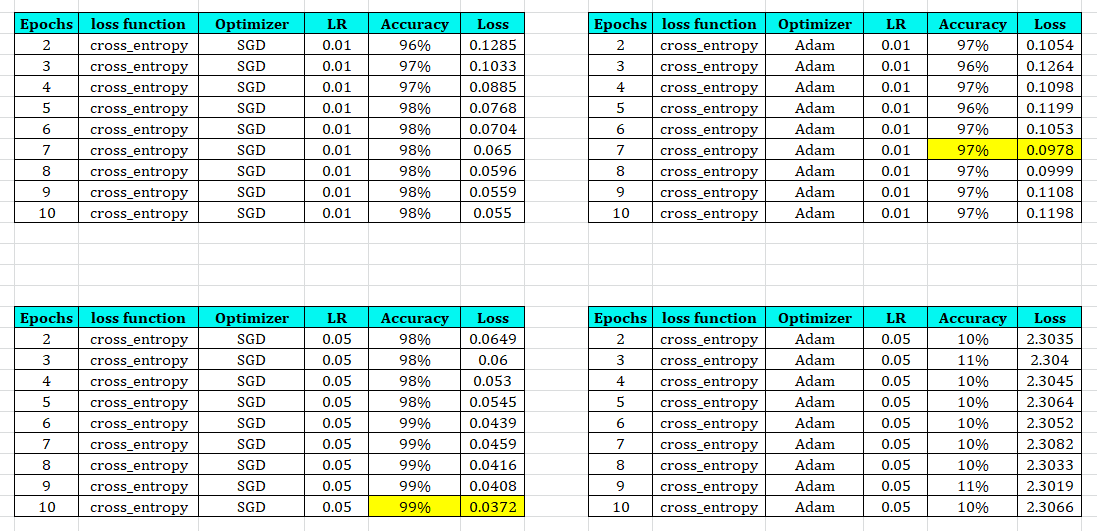

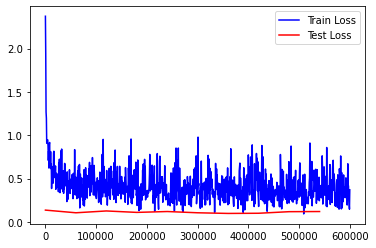

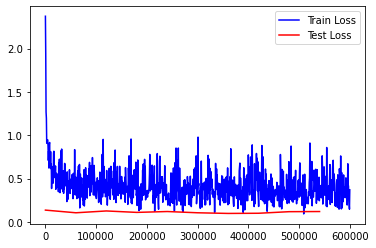

In [21]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter[:-1], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
fig